# Problem 3 - Apache Spark Walkthrough

In this problem, we'll be working with california housing data and using Spark to do parrallelized Linear Regression on some of its columns. The results aren't very accurate at all, but it's a good introduction on various functionalities that Spark has.

In [1]:
!pip install pyspark

     |████████████████████████████████| 204.2 MB 27 kB/s s eta 0:00:01
     |████████████████████████████████| 198 kB 43.6 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612244 sha256=d59e79b82af23155de9a99e36fdefe240043d92f78e9236279000a861fda6c5d
  Stored in directory: /root/.cache/pip/wheels/5e/34/fa/b37b5cef503fc5148b478b2495043ba61b079120b7ff379f9b
Successfully built pyspark
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

import matplotlib.pyplot as plt

## Housing Data Set

The California Housing data set appeared in a 1997 paper titled *Sparse Spatial Autoregressions*, written by Pace, R. Kelley and Ronald Barry and published in the Statistics and Probability Letters journal. The researchers built this data set by using the 1990 California census data.

The data contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). In this sample a block group on average includes 1425.5 individuals living in a geographically compact area.

These spatial data contain 20,640 observations on housing prices with 9 economic variables:

<p style="text-align: justify;"></p>
<pre><strong>Longitude:</strong>refers to the angular distance of a geographic place north or south of the earth’s equator for each block group
<strong>Latitude :</strong>refers to the angular distance of a geographic place east or west of the earth’s equator for each block group
<strong>Housing Median Age:</strong>is the median age of the people that belong to a block group. Note that the median is the value that lies at the midpoint of a frequency distribution of observed values
<strong>Total Rooms:</strong>is the total number of rooms in the houses per block group
<strong>Total Bedrooms:</strong>is the total number of bedrooms in the houses per block group
<strong>Population:</strong>is the number of inhabitants of a block group
<strong>Households:</strong>refers to units of houses and their occupants per block group
<strong>Median Income:</strong>is used to register the median income of people that belong to a block group
<strong>Median House Value:</strong>is the dependent variable and refers to the median house value per block group
</pre>

What's more, we also learn that all the block groups have zero entries for the independent and dependent variables have been excluded from the data.

The Median house value is the dependent variable and will be assigned the role of the target variable in our ML model.

In [3]:
spark = SparkSession.builder.master("local[2]").appName("Linear-Regression-California-Housing").getOrCreate()
path = '../input/hausing-data/cal_housing.data'

schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)

housing_df = spark.read.csv(path=path, schema=schema).cache()

# PART A: Basic Spark Commands

## (a) Display the first five rows of the Spark dataframe


In [4]:
housing_df.show(5)

+-------+-----+------+--------+--------+------+--------+------+--------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|   medhv|
+-------+-----+------+--------+--------+------+--------+------+--------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|452600.0|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|358500.0|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|352100.0|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|341300.0|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|342200.0|
+-------+-----+------+--------+--------+------+--------+------+--------+
only showing top 5 rows



## (b) Create a new 1x1 dataframe, result, which contains the average of the population column

Your result should be around 1425

In [5]:
result = housing_df.agg({'pop':'avg'})
result.show(1)

+------------------+
|          avg(pop)|
+------------------+
|1425.4767441860465|
+------------------+



## (c) Save the pandas version of housing_df as pandas_housing_df

Feel free to lookup documentation on how this is done

In [6]:
pandas_housing_df = housing_df.toPandas()

Text(0.5, 1.0, 'Histogram of Median Ages in California Houses')

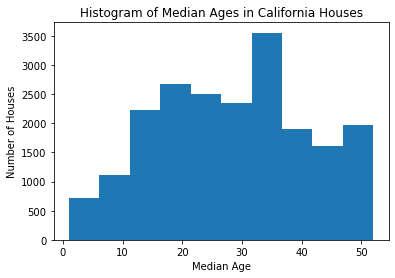

In [7]:
#Checks if your code worked by plotting median age
plt.hist(pandas_housing_df['medage'])
plt.xlabel('Median Age')
plt.ylabel('Number of Houses')
plt.title('Histogram of Median Ages in California Houses')

## PART B: Basic Spark Machine Learning

## (d) First we define a set of feature columns that we would like to use as an input. 
Right now, lets go with Median Age, Total Bedrooms, Median Income, and Total Rooms

In [44]:
feature_cols = ['medage','totbdrms','medinc','totrooms']

## (e) Use VectorAssembler to create a column names "features" which contains the desired features

In [45]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_df = assembler.transform(housing_df)

In [46]:
assembled_df.show(10, truncate=False)

+-------+-----+------+--------+--------+------+--------+------+--------+--------------------------------------+
|long   |lat  |medage|totrooms|totbdrms|pop   |houshlds|medinc|medhv   |features                              |
+-------+-----+------+--------+--------+------+--------+------+--------+--------------------------------------+
|-122.23|37.88|41.0  |880.0   |129.0   |322.0 |126.0   |8.3252|452600.0|[41.0,129.0,8.325200080871582,880.0]  |
|-122.22|37.86|21.0  |7099.0  |1106.0  |2401.0|1138.0  |8.3014|358500.0|[21.0,1106.0,8.301400184631348,7099.0]|
|-122.24|37.85|52.0  |1467.0  |190.0   |496.0 |177.0   |7.2574|352100.0|[52.0,190.0,7.257400035858154,1467.0] |
|-122.25|37.85|52.0  |1274.0  |235.0   |558.0 |219.0   |5.6431|341300.0|[52.0,235.0,5.643099784851074,1274.0] |
|-122.25|37.85|52.0  |1627.0  |280.0   |565.0 |259.0   |3.8462|342200.0|[52.0,280.0,3.8461999893188477,1627.0]|
|-122.25|37.85|52.0  |919.0   |213.0   |413.0 |193.0   |4.0368|269700.0|[52.0,213.0,4.036799907684326,91

## (f) Randomly split the data into 80% train data and 20% testing data

In [47]:
train_data, test_data = assembled_df.randomSplit([.8,.2])

In [48]:
train_data.show(10)

+-------+-----+------+--------+--------+------+--------+------+--------+--------------------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|   medhv|            features|
+-------+-----+------+--------+--------+------+--------+------+--------+--------------------+
|-124.35|40.54|  52.0|  1820.0|   300.0| 806.0|   270.0|3.0147| 94600.0|[52.0,300.0,3.014...|
|-124.27|40.69|  36.0|  2349.0|   528.0|1194.0|   465.0|2.5179| 79000.0|[36.0,528.0,2.517...|
|-124.26|40.58|  52.0|  2217.0|   394.0| 907.0|   369.0|2.3571|111400.0|[52.0,394.0,2.357...|
|-124.25|40.28|  32.0|  1430.0|   419.0| 434.0|   187.0|1.9417| 76100.0|[32.0,419.0,1.941...|
|-124.23|40.81|  52.0|  1112.0|   209.0| 544.0|   172.0|3.3462| 50800.0|[52.0,209.0,3.346...|
|-124.23|41.75|  11.0|  3159.0|   616.0|1343.0|   479.0|2.4805| 73200.0|[11.0,616.0,2.480...|
|-124.21|40.75|  32.0|  1218.0|   331.0| 620.0|   268.0|1.6528| 58100.0|[32.0,331.0,1.652...|
|-124.21|41.77|  17.0|  3461.0|   722.0|1947.0|   647.0|2.57

In [49]:
test_data.show(10)

+-------+-----+------+--------+--------+------+--------+------+--------+--------------------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|   medhv|            features|
+-------+-----+------+--------+--------+------+--------+------+--------+--------------------+
| -124.3| 41.8|  19.0|  2672.0|   552.0|1298.0|   478.0|1.9797| 85800.0|[19.0,552.0,1.979...|
| -124.3|41.84|  17.0|  2677.0|   531.0|1244.0|   456.0|3.0313|103600.0|[17.0,531.0,3.031...|
|-124.23|40.54|  52.0|  2694.0|   453.0|1152.0|   435.0|3.0806|106700.0|[52.0,453.0,3.080...|
|-124.22|41.73|  28.0|  3003.0|   699.0|1530.0|   653.0|1.7038| 78300.0|[28.0,699.0,1.703...|
|-124.21|41.75|  20.0|  3810.0|   787.0|1993.0|   721.0|2.0074| 66900.0|[20.0,787.0,2.007...|
|-124.19|40.73|  21.0|  5694.0|  1056.0|2907.0|   972.0|3.5363| 90100.0|[21.0,1056.0,3.53...|
|-124.18|40.79|  40.0|  1398.0|   311.0| 788.0|   279.0|1.4668| 64600.0|[40.0,311.0,1.466...|
|-124.17|40.62|  32.0|  1595.0|   309.0| 706.0|   277.0|2.89

## (g) Set linearModel equal to the result of fitting the given linear regression on the training data

In [50]:
lr = (LinearRegression(featuresCol='features', labelCol="medhv", predictionCol='predmedhv', 
                               maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False))

In [51]:
linearModel = lr.fit(train_data)

## (h) Use the linearModel to predict on the test_data

In [52]:
predictions = linearModel.transform(test_data)

In [53]:
predictions.show(10)

+-------+-----+------+--------+--------+------+--------+------+--------+--------------------+------------------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|   medhv|            features|         predmedhv|
+-------+-----+------+--------+--------+------+--------+------+--------+--------------------+------------------+
| -124.3| 41.8|  19.0|  2672.0|   552.0|1298.0|   478.0|1.9797| 85800.0|[19.0,552.0,1.979...|100510.18644641551|
| -124.3|41.84|  17.0|  2677.0|   531.0|1244.0|   456.0|3.0313|103600.0|[17.0,531.0,3.031...| 143136.8331871637|
|-124.23|40.54|  52.0|  2694.0|   453.0|1152.0|   435.0|3.0806|106700.0|[52.0,453.0,3.080...|207092.14219764498|
|-124.22|41.73|  28.0|  3003.0|   699.0|1530.0|   653.0|1.7038| 78300.0|[28.0,699.0,1.703...|116478.93252905562|
|-124.21|41.75|  20.0|  3810.0|   787.0|1993.0|   721.0|2.0074| 66900.0|[20.0,787.0,2.007...| 112862.6051495002|
|-124.19|40.73|  21.0|  5694.0|  1056.0|2907.0|   972.0|3.5363| 90100.0|[21.0,1056.0,3.53...|  1

## (i) Print root mean squared error for the linear model

If you did everything correctly, the MSE should be around 80,000. 

In [56]:
mse = linearModel.summary.rootMeanSquaredError
print("MSE:",mse)

MSE: 77966.83440225315


## (j) Stop Spark

In [ ]:
spark.stop()

### CREDITS:
THIS NOTEBOOK IS HEAVILY INSPIRED BY THE ONE BY FATMAKURSUN WHICH YOU CAN FIND HERE https://www.kaggle.com/fatmakursun/pyspark-ml-tutorial-for-beginners. SOME BLOCKS OF CODE, FOR EXAMPLE LOADING THE DATASET, ARE TAKEN DIRECTLY FROM IT.